# Projet : Optimisation du Customer Lifetime Value (CLV)

L’objectif de ce projet est de mieux comprendre le comportement des clients afin d’optimiser leur valeur à long terme. Nous allons analyser les interactions passées, segmenter les clients selon leurs profils d’achat et construire des modèles prédictifs capables d’estimer la valeur future d’un client.

##  Objectifs du projet

### Ce projet inclura :

- **Analyse RFM**  
  Étudier la Récence, la Fréquence et le Montant des achats afin d’évaluer la valeur actuelle des clients.

- **Segmentation Client**  
  Utilisation d’algorithmes non supervisés (ex : K-Means) pour identifier des groupes de clients homogènes et détecter les segments les plus stratégiques.

- **Prédiction du CLV**  
  Mise en place de modèles d’apprentissage automatique (régression ou classification) pour estimer la valeur future d’un client et orienter les actions marketing.

---

L’ensemble de ces étapes permettra d’optimiser les investissements marketing, d’améliorer la fidélisation et d’augmenter la rentabilité globale grâce à une compréhension approfondie du cycle de vie client.


In [ ]:
import pandas as pd 
from utils.config import create_db_engine 


df = pd.read_excel('data/Online Retail.xlsx')

df['Total_Price'] = df['Quantity'] * df['UnitPrice']

print(f"Lignes avant nettoyage: {len(df)}")
df.dropna(subset=['CustomerID'], inplace=True)
print(f"Lignes après suppression des NaN CustomerID: {len(df)}")

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print(f"Lignes après exclusion des retours/erreurs: {len(df)}")

df['CustomerID'] = df['CustomerID'].astype(str)


engine = create_db_engine()
df.to_sql(
        name='transactions',   
        con=engine,              
        if_exists='replace',     
        index=False,
        chunksize=10000              
    )
print("les données ont été transféré avec succès")


Lignes avant nettoyage: 541909
Lignes après suppression des NaN CustomerID: 406829
Lignes après exclusion des retours/erreurs: 397884
les données ont été transféré avec succès


In [3]:
import pandas as pd
from utils.config import create_db_engine 

engine = create_db_engine()

rfm_query = """
SELECT
    CustomerID,
    DATEDIFF((SELECT MAX(InvoiceDate) FROM transactions), MAX(InvoiceDate)) AS Recency_Days,
    COUNT(DISTINCT InvoiceNo) AS Frequence,
    SUM(UnitPrice * Quantity) AS Montant 
FROM
    transactions
GROUP BY
    CustomerID;
"""

rfm_df = pd.read_sql_query(rfm_query, engine)

print("DataFrame RFM créée et prête pour la segmentation.")

DataFrame RFM créée et prête pour la segmentation.


### I/ Exploration des données

In [5]:
rfm_df.head()


,CustomerID,Recency_Days,Frequence,Montant
0,12346.0,325,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,310,1,334.40


In [6]:
rfm_df.describe()

,Recency_Days,Frequence,Montant
count,4338.000000,4338.000000,4338.000000
mean,92.059474,4.272015,2054.266460
std,100.012264,7.697998,8989.230441
min,0.000000,1.000000,3.750000
25%,17.000000,1.000000,307.415000
50%,50.000000,2.000000,674.485000
75%,141.750000,5.000000,1661.740000
max,373.000000,209.000000,280206.020000


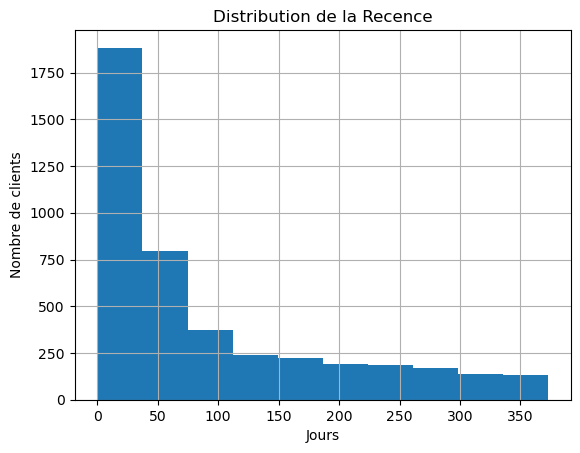

In [8]:
import matplotlib.pyplot as plt
rfm_df['Recency_Days'].hist()
plt.title("Distribution de la Recence")
plt.xlabel("Jours")
plt.ylabel("Nombre de clients")
plt.show()

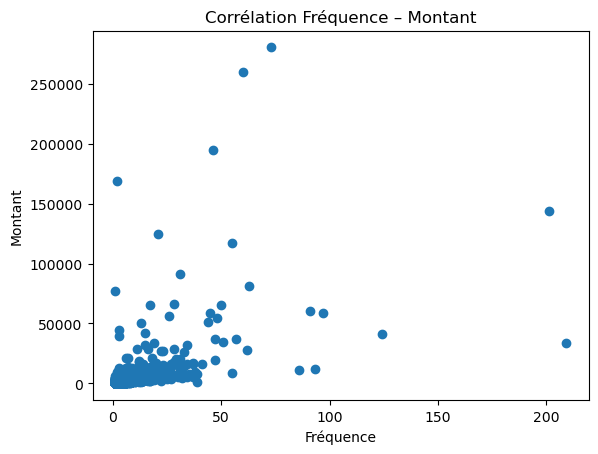

In [11]:
plt.scatter(rfm_df['Frequence'], rfm_df['Montant'])
plt.title("Corrélation Fréquence – Montant")
plt.xlabel("Fréquence")
plt.ylabel("Montant")
plt.show()


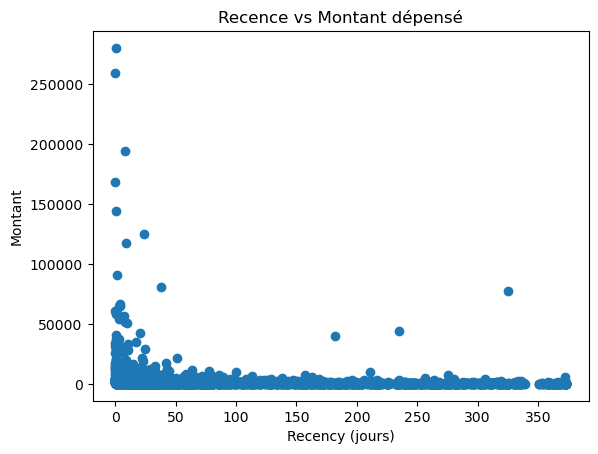

In [12]:
plt.scatter(rfm_df['Recency_Days'], rfm_df['Montant'])
plt.title("Recence vs Montant dépensé")
plt.xlabel("Recency (jours)")
plt.ylabel("Montant")
plt.show()


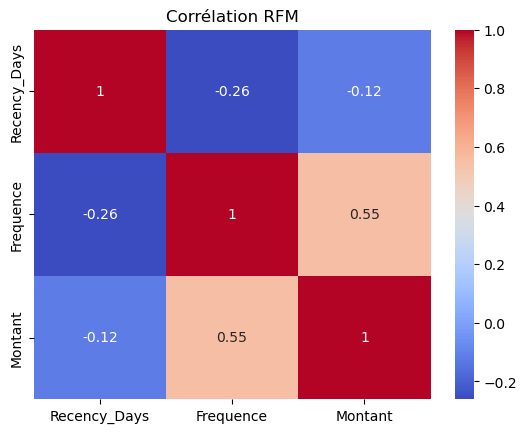

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(rfm_df[['Recency_Days','Frequence','Montant']].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation RFM")
plt.show()


### II/ Préparation des données (normalisation) et modèle non supervisée (K-Means)

In [15]:
import numpy as np

# Application de la transformation Log(x+1) aux colonnes asymétriques
rfm_df['Log_Frequence'] = np.log1p(rfm_df['Frequence'])
rfm_df['Log_Montant'] = np.log1p(rfm_df['Montant'])

# Nous devons appliquer la transformation Log(x+1) à la Récence
# pour les mêmes raisons, surtout si des clients très récents ont Recency_Days = 0.
rfm_df['Log_Recency'] = np.log1p(rfm_df['Recency_Days'])

In [16]:
rfm_df.head()

,CustomerID,Recency_Days,Frequence,Montant,Log_Frequence,Log_Montant,Log_Recency
0,12346.0,325,1,77183.60,0.693147,11.253955,5.786897
1,12347.0,2,7,4310.00,2.079442,8.368925,1.098612
2,12348.0,75,4,1797.24,1.609438,7.494564,4.330733
3,12349.0,18,1,1757.55,0.693147,7.472245,2.944439
4,12350.0,310,1,334.40,0.693147,5.815324,5.739793


In [17]:
from sklearn.preprocessing import StandardScaler

# Sélection des colonnes Log transformées
rfm_log_data = rfm_df[['Log_Recency', 'Log_Frequence', 'Log_Montant']]

# Initialisation et ajustement (fit) du scaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log_data)

# Conversion en DataFrame pour la clarté
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_log_data.columns)

print("Données prêtes pour le clustering K-Means.")

Données prêtes pour le clustering K-Means.


In [18]:
rfm_scaled_df

,Log_Recency,Log_Frequence,Log_Montant
0,1.435416,-0.955214,3.706225
1,-1.953393,1.074425,1.411843
2,0.382865,0.386304,0.716489
3,-0.619183,-0.955214,0.698739
4,1.401368,-0.955214,-0.618962
...,...,...,...
4333,1.320288,-0.955214,-1.106875
4334,1.010106,-0.955214,-1.740933
4335,-1.244425,-0.361583,-1.118121
4336,-1.745449,2.178004,0.838297


In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
# Nous testons un éventail de k de 1 à 10
range_k = range(1, 11)

for k in range_k:
    # 1. Instancier et entraîner K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(rfm_scaled_df)
    
    # 2. Récupérer et stocker la valeur WCSS (Inertia)
    wcss.append(kmeans.inertia_)


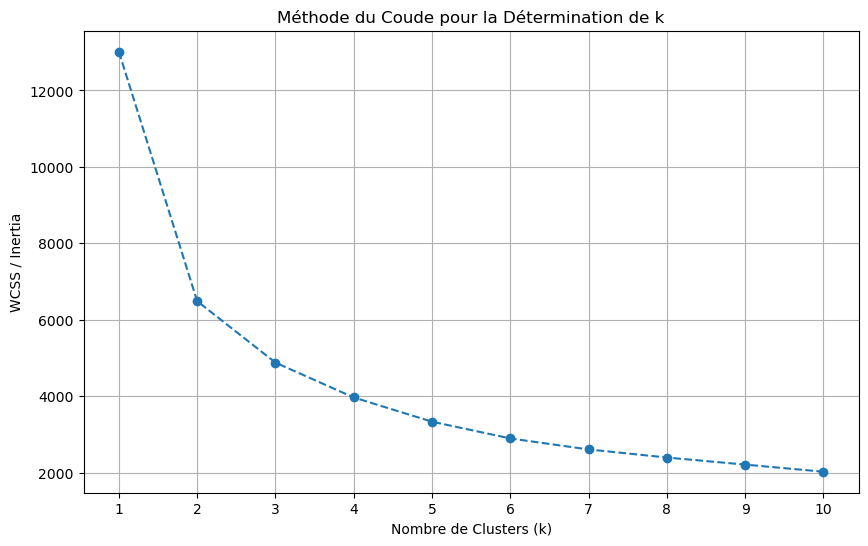

In [20]:
# Tracé du coude
plt.figure(figsize=(10, 6))
plt.plot(range_k, wcss, marker='o', linestyle='--')
plt.title('Méthode du Coude pour la Détermination de k')
plt.xlabel('Nombre de Clusters (k)')
plt.ylabel('WCSS / Inertia')
plt.xticks(range_k)
plt.grid(True)
plt.show()

In [21]:
from sklearn.cluster import KMeans

# Choisir le k optimal déterminé
optimal_k = 4

# Entraînement final du modèle
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_final.fit(rfm_scaled_df)

# Attribution des labels aux clients
# Nous ajoutons les labels au DataFrame RFM original (non-scalé)
rfm_df['Cluster_Label'] = kmeans_final.labels_

print(f"Clustering final réalisé avec k={optimal_k}. Les labels de cluster sont ajoutés au DataFrame.")

Clustering final réalisé avec k=4. Les labels de cluster sont ajoutés au DataFrame.


### profilage des segments 

In [22]:
cluster_profile = rfm_df.groupby('Cluster_Label')[['Recency_Days', 'Frequence', 'Montant']].mean()

print(cluster_profile.sort_values(by='Montant', ascending=False))

               Recency_Days  Frequence      Montant
Cluster_Label                                      
3                 10.803161  13.863506  8183.321997
1                 64.655434   4.242628  1857.644240
0                 19.860849   1.981132   509.290519
2                185.592408   1.348475   360.245004


# Analyse de Segmentation Client (Modèle RFM + Clustering)

L'analyse RFM combinée au clustering permet d’identifier des groupes de clients présentant des comportements d’achat distincts. Voici une synthèse interprétée des **4 segments identifiés** :

---

## **Cluster 3 — Champions **
### **Profil**
- Excellente récence, fréquence et valeur monétaire  
- Clients actifs, récents et à très fort pouvoir d’achat  
- Représentent une part majeure du chiffre d’affaires

### **Stratégie Recommandée**
- **Récompenser & fidéliser** : programmes VIP, accès anticipé aux nouveautés  
- Offrir des avantages exclusifs pour renforcer leur engagement  
- Solliciter leur feedback : ce segment influence fortement le CLV

---

## **Cluster 1 — Clients Fidèles à Potentiel**
### **Profil**
- Scores RFM solides  
- Dernier achat datant d’environ 65 jours  
- Valeur monétaire élevée (≈ 1857 €)

### **Stratégie Recommandée**
- **Réactiver avant qu'ils ne deviennent à risque**  
- Emails personnalisés ou offres ciblées  
- Incentives modérés : réductions raisonnables, points bonus  
- Proposer des produits premium pour augmenter leur CLV

---

## **Cluster 0 — Nouveaux Clients**
### **Profil**
- Récence très faible (achat récent)  
- Faible fréquence et faible montant  
- Correspond à des clients ayant réalisé un premier achat

### **Stratégie Recommandée**
- **Développer la relation**  
- Onboarding client : tutoriels, guides d’utilisation  
- Encourager un deuxième achat (rabais d’accueil, cross-selling léger)  
- Construire une relation long terme pour maximiser leur futur CLV

---

## **Cluster 2 — Clients Dormants / Perdus**
### **Profil**
- Récence très élevée (≈ 186 jours)  
- Faible fréquence et faible valeur monétaire  
- En voie de désengagement total

### **Stratégie Recommandée**
- **Reconquérir** : offres fortes, campagne “Dernière chance”  
- Ou **ne pas investir davantage** si l’historique montre peu de réactivation  
- Optimise les coûts marketing en évitant les actions inefficaces

---

#  Conclusion

Cette segmentation permet :  
- d’identifier les clients les plus rentables (Champions)  
- de sécuriser la valeur future (Fidèles à potentiel)  
- d’accompagner les nouveaux clients vers un meilleur CLV  
- d’éviter les dépenses inutiles sur les segments peu réactifs  

Une base solide pour une stratégie CLV efficace et personnalisée.
